In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
def generate_problem(n, d, s, std=0.06):
    # Generate xs
    # vectors with entries in [0.5, 1] and [-1, -0.5]
    # respectively
    assert s % 2 == 0, "s needs to be divisible by 2"
    xsp = 0.5 * (np.random.rand(s // 2) + 1)
    xsn = - 0.5 * (np.random.rand(s // 2) + 1)
    xsparse = np.hstack([xsp, xsn, np.zeros(d - s)])
    random.shuffle(xsparse)
    # Generate A
    A = np.random.randn(n, d)
    # Generate eps
    y = A @ xsparse + std * np.random.randn(n)
    return xsparse, A, y

In [3]:
def PSGA(A, y, lamb_da, num_iterations=100000):
    n, d = A.shape
    x = np.zeros(d)  # Here we initialize x
    L = np.linalg.norm(A, ord='fro') ** 2  # we take the Frobenius norm of A
    gamma_sum = 0
    weighted_sum = np.zeros(d)  # compute the ergodic mean
    
    objective_values = []  # track objective function values
    ergodic_objective_values = []  # track ergodic mean objective values

    for k in range(1, num_iterations + 1):
        # step size
        gamma_k = n / (L * np.sqrt(k + 1))
        gamma_sum += gamma_k
        
        # randomly sample a row
        i_k = np.random.randint(0, n)
        a_i = A[i_k,:]
        y_i = y[i_k]
        
        # compute gradient
        grad = ((np.dot(a_i, x) - y_i) * a_i).T
        
        # proximal update
        x = np.sign(x - gamma_k * grad) * np.maximum(np.abs(x - gamma_k * grad) - gamma_k * lamb_da, 0)
        
        # update the weighted sum for the ergodic mean
        weighted_sum += gamma_k * x
        
        # compute ergodic mean
        ergodic_x = weighted_sum / gamma_sum
        
        # store objective values
        obj_val = 0.5 / n * np.linalg.norm(A @ x - y) ** 2 + lamb_da * np.linalg.norm(x, 1)
        ergodic_obj_val = 0.5 / n * np.linalg.norm(A @ ergodic_x - y) ** 2 + lamb_da * np.linalg.norm(ergodic_x, 1)
        objective_values.append(obj_val)
        ergodic_objective_values.append(ergodic_obj_val)

    return x, objective_values, ergodic_objective_values


In [4]:
def RCPGA(A, y, lamb_da, num_iterations=100000):
    n, d = A.shape
    x = np.zeros(d)  # Initialize x
    Ls = np.sum(A ** 2, axis=0) / n  # Coordinate-wise Lipschitz constants
    
    objective_values = []  # To track objective function values

    for k in range(num_iterations):
        
        # Randomly select a coordinate
        j_k = np.random.randint(0, d)
        
        # Compute gradient for the selected coordinate
        grad_j = (1 / n) * np.sum((A @ x - y) * A[:, j_k])
        
        # Proximal update for the selected coordinate
        x[j_k] = np.sign(x[j_k] - grad_j / Ls[j_k]) * \
                 np.maximum(np.abs(x[j_k] - grad_j / Ls[j_k]) - lamb_da / Ls[j_k], 0)
        
        # Store objective values
        obj_val = 0.5 / n * np.linalg.norm(A @ x - y) ** 2 + lamb_da * np.linalg.norm(x, 1)
        objective_values.append(obj_val)

    return x, objective_values



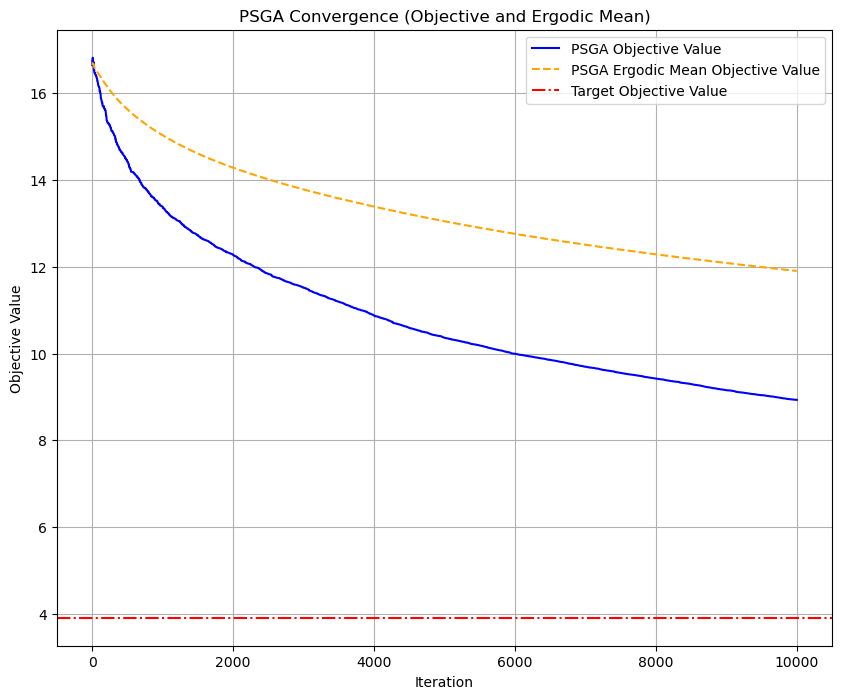

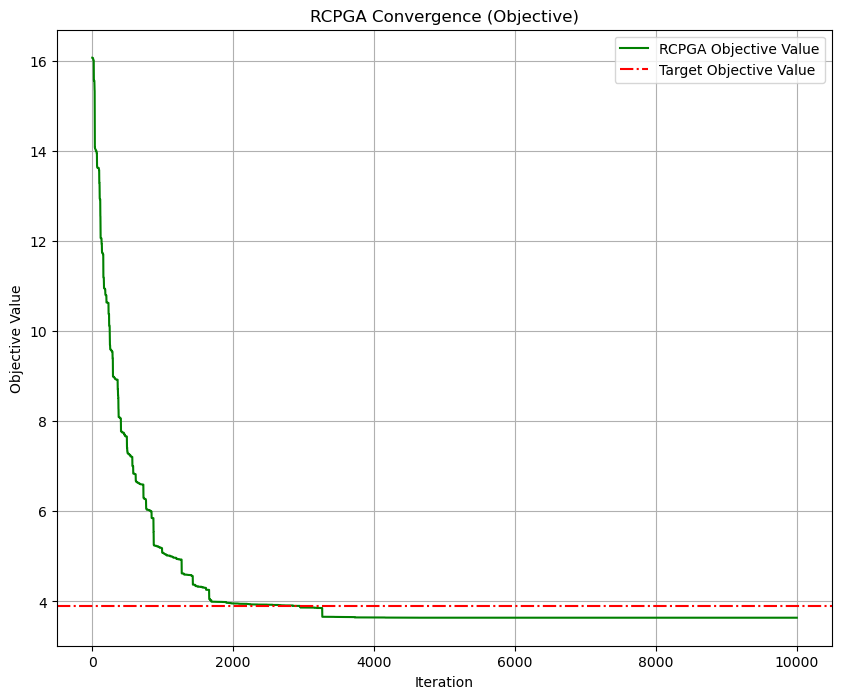

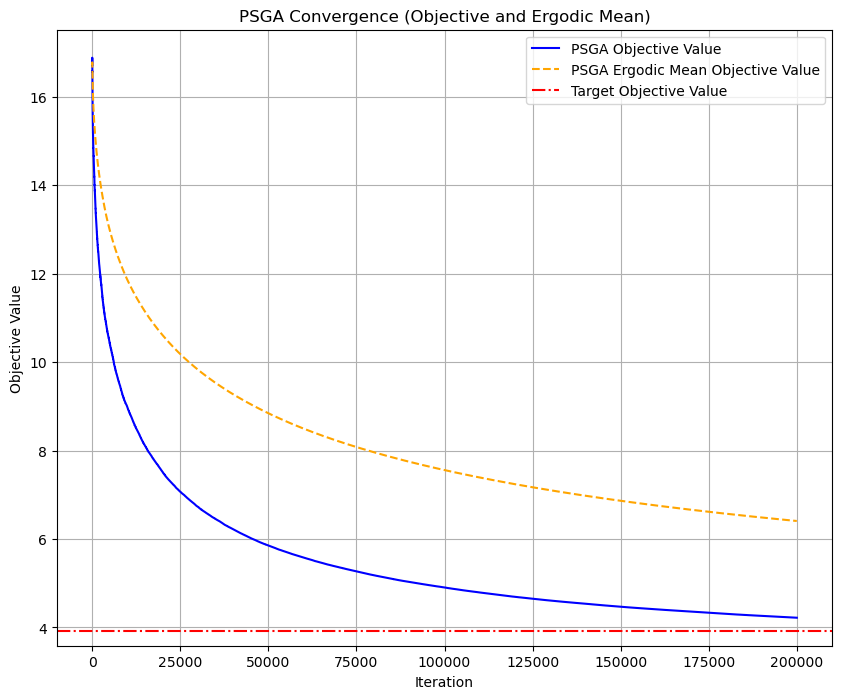

In [7]:
# Parameters for generating the problem
n, d, s = 1000, 500, 50
lamb_da = 0.1
num_iterations = 10000
num_more_iterations = 190000

# Generate problem data
x_star, A, y = generate_problem(n, d, s)

# Target objective value
target_obj = 0.5/n * np.linalg.norm(x_star, 1) + lamb_da * np.linalg.norm(x_star, 1)

# Run PSGA
x_psga, obj_values_psga, ergodic_obj_values_psga = PSGA(A, y, lamb_da, num_iterations)

# Run RCPGA
x_rcpga, obj_values_rcpga = RCPGA(A, y, lamb_da, num_iterations)

# Plot PSGA results and target objective value
plt.figure(figsize=(10, 8))
plt.plot(obj_values_psga, label="PSGA Objective Value", color='blue')
plt.plot(ergodic_obj_values_psga, label="PSGA Ergodic Mean Objective Value", linestyle='--', color='orange')
plt.axhline(y=target_obj, color='red', linestyle='-.', label="Target Objective Value")
plt.xlabel("Iteration")
plt.ylabel("Objective Value")
plt.title("PSGA Convergence (Objective and Ergodic Mean)")
plt.legend()
plt.grid()
plt.savefig("psga.png")
plt.show()

# Plot RCPGA results
plt.figure(figsize=(10, 8))
plt.plot(obj_values_rcpga, label="RCPGA Objective Value", color='green')
plt.axhline(y=target_obj, color='red', linestyle='-.', label="Target Objective Value")
plt.xlabel("Iteration")
plt.ylabel("Objective Value")
plt.title("RCPGA Convergence (Objective)")
plt.legend()
plt.grid()
plt.savefig("rcpga.png")
plt.show()


# Run PSGA with more iterations
x_psga, obj_values_psga, ergodic_obj_values_psga = PSGA(A, y, lamb_da, num_iterations + num_more_iterations)
# Plot PSGA in more iterations
plt.figure(figsize=(10, 8))
plt.plot(obj_values_psga, label="PSGA Objective Value", color='blue')
plt.plot(ergodic_obj_values_psga, label="PSGA Ergodic Mean Objective Value", linestyle='--', color='orange')
plt.axhline(y=target_obj, color='red', linestyle='-.', label="Target Objective Value")
plt.xlabel("Iteration")
plt.ylabel("Objective Value")
plt.title("PSGA Convergence (Objective and Ergodic Mean)")
plt.legend()
plt.grid()
plt.savefig("psga_100k.png")
plt.show()
